In [1]:
import numpy as np
import utils.mnist_reader as mnist_reader
import matplotlib.pyplot as plt

In [2]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

perm = np.random.permutation(X_train.shape[0])
num_val = 10000
val_idx = perm[:num_val]
train_idx = perm[num_val:]

X_val = X_train[val_idx]
y_val = y_train[val_idx]
X_train = X_train[train_idx]
y_train = y_train[train_idx]

In [3]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation_func='relu'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.01
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.01
        self.bias1 = np.zeros((1, hidden_size))
        self.bias2 = np.zeros((1, output_size))
        self.activation_func = activation_func

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, x):
        self.z1 = x.dot(self.weights1) + self.bias1
        if self.activation_func == 'relu':
            self.a1 = self.relu(self.z1)
        else:
            self.a1 = np.tanh(self.z1)
        self.z2 = self.a1.dot(self.weights2) + self.bias2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true])
        loss = np.sum(log_likelihood) / m
        return loss

    def backward(self, x, y_true):
        m = x.shape[0]
        delta2 = self.a2
        delta2[range(m), y_true] -= 1
        dw2 = (self.a1.T).dot(delta2) / m
        db2 = np.sum(delta2, axis=0, keepdims=True) / m
        delta1 = delta2.dot(self.weights2.T)
        if self.activation_func == 'relu':
            delta1[self.z1 <= 0] = 0
        else:
            delta1 *= (1 - np.power(self.a1, 2))
        dw1 = np.dot(x.T, delta1) / m
        db1 = np.sum(delta1, axis=0, keepdims=True) / m
        return dw1, db1, dw2, db2

    def update_params(self, dw1, db1, dw2, db2, learning_rate):
        self.weights1 -= learning_rate * dw1
        self.bias1 -= learning_rate * db1
        self.weights2 -= learning_rate * dw2
        self.bias2 -= learning_rate * db2

In [4]:
def train_and_validate(model, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(epochs):
        # Training
        permutation = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[permutation]
        y_shuffled = y_train[permutation]
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]
            y_pred = model.forward(X_batch)
            loss = model.compute_loss(y_pred, y_batch)
            dw1, db1, dw2, db2 = model.backward(X_batch, y_batch)
            model.update_params(dw1, db1, dw2, db2, learning_rate)

        # Validation
        y_pred_train = model.forward(X_train)
        train_loss = model.compute_loss(y_pred_train, y_train)
        history['train_loss'].append(train_loss)
        
        y_pred_val = model.forward(X_val)
        val_loss = model.compute_loss(y_pred_val, y_val)
        val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == y_val)
        
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    return history

In [5]:
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Epoch 1/50, Train Loss: 0.5768, Val Loss: 0.6097, Val Accuracy: 0.7794
Epoch 2/50, Train Loss: 0.4541, Val Loss: 0.4706, Val Accuracy: 0.8337
Epoch 3/50, Train Loss: 0.8347, Val Loss: 0.8744, Val Accuracy: 0.7654
Epoch 4/50, Train Loss: 0.5217, Val Loss: 0.5631, Val Accuracy: 0.7999
Epoch 5/50, Train Loss: 0.3743, Val Loss: 0.4211, Val Accuracy: 0.8526
Epoch 6/50, Train Loss: 0.2974, Val Loss: 0.3425, Val Accuracy: 0.8770
Epoch 7/50, Train Loss: 0.4529, Val Loss: 0.5007, Val Accuracy: 0.8311
Epoch 8/50, Train Loss: 0.2986, Val Loss: 0.3610, Val Accuracy: 0.8707
Epoch 9/50, Train Loss: 0.4080, Val Loss: 0.4705, Val Accuracy: 0.8246
Epoch 10/50, Train Loss: 0.2945, Val Loss: 0.3664, Val Accuracy: 0.8668
Epoch 11/50, Train Loss: 0.2557, Val Loss: 0.3395, Val Accuracy: 0.8855
Epoch 12/50, Train Loss: 0.2800, Val Loss: 0.3662, Val Accuracy: 0.8739
Epoch 13/50, Train Loss: 0.4207, Val Loss: 0.5140, Val Accuracy: 0.8270
Epoch 14/50, Train Loss: 0.2566, Val Loss: 0.3483, Val Accuracy: 0.8762
E

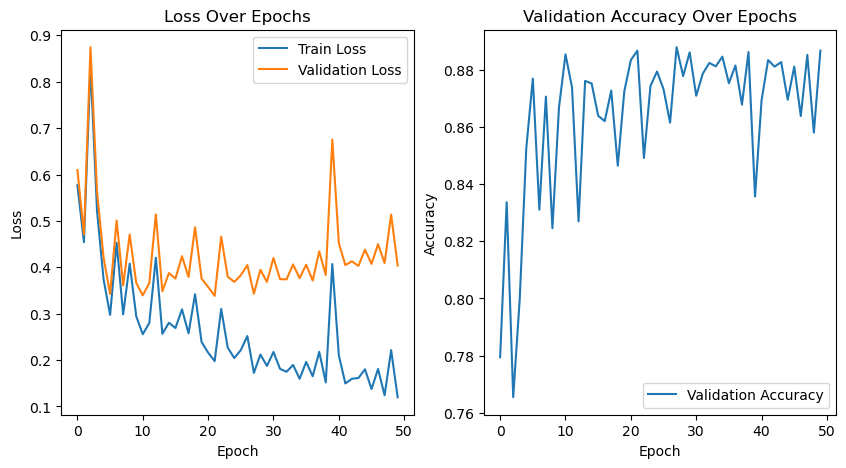

In [11]:
model = NeuralNetwork(784, 128, 10)
history = train_and_validate(model, X_train, y_train, X_val, y_val, 50, 0.001, 64)
plot_history(history)

In [12]:
def save_weights(model, filename):
    np.savez(filename, weights1=model.weights1, bias1=model.bias1,
             weights2=model.weights2, bias2=model.bias2)

def load_weights(filename, model):
    data = np.load(filename)
    model.weights1 = data['weights1']
    model.bias1 = data['bias1']
    model.weights2 = data['weights2']
    model.bias2 = data['bias2']

# 保存权重和偏置
save_weights(model, 'fashion_mnist_weights.npz')

# loaded_model = NeuralNetwork(784, 128, 10)
# load_weights('fashion_mnist_weights.npz', loaded_model)

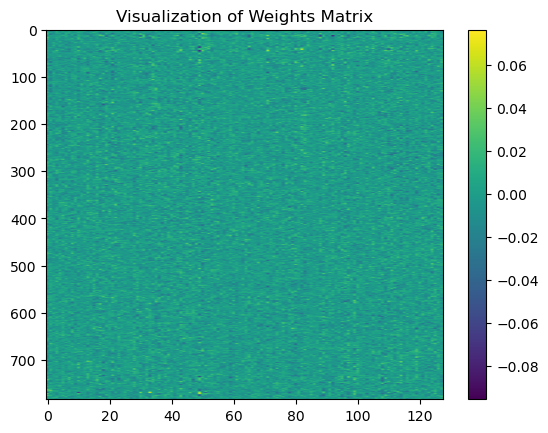

In [13]:
plt.imshow(model.weights1, aspect='auto')
plt.colorbar()
plt.title('Visualization of Weights Matrix')
plt.show()